# <center> Analyzing the "Horses for Courses" Horse Racing Dataset from Kaggle </center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare, ttest_ind, zscore

%matplotlib inline

#Supresses scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import warnings
warnings.filterwarnings('ignore')

In [2]:
fields = ["position_again","bf_odds","venue_name","date","market_name","condition",
          "barrier","handicap_weight","last_twenty_starts","prize_money","sex",
          "age","jockey_sex","days_since_last_run","overall_starts","overall_wins",
          "overall_places","track_starts","track_wins","track_places","firm_starts",
          "firm_wins","firm_places","good_starts","good_wins","good_places",
          "slow_starts","slow_wins","slow_places","soft_starts","soft_wins",
          "soft_places","heavy_starts","heavy_wins","heavy_places","distance_starts",
          "distance_wins","distance_places"]

df = pd.read_csv("horses.csv", usecols=fields, skipinitialspace=True, low_memory=False)

df.head()

,position_again,bf_odds,venue_name,date,market_name,condition,barrier,handicap_weight,prize_money,sex,...,slow_places,soft_starts,soft_wins,soft_places,heavy_starts,heavy_wins,heavy_places,distance_starts,distance_wins,distance_places
0,1.00,2.88,Echuca,2016-06-27,R3 1200m Mdn,HVY9,3.00,58.50,2160.00,Gelding,...,1.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00
1,2.00,15.00,Echuca,2016-06-27,R3 1200m Mdn,HVY9,10.00,58.50,21175.00,Gelding,...,1.00,2.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,1.00
2,3.00,95.00,Echuca,2016-06-27,R3 1200m Mdn,HVY9,6.00,56.50,28855.00,Mare,...,0.00,5.00,0.00,0.00,3.00,0.00,0.00,4.00,0.00,0.00
3,nan,20.00,Echuca,2016-06-27,R3 1200m Mdn,HVY9,2.00,56.50,1475.00,Filly,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
4,nan,2.74,Echuca,2016-06-27,R3 1200m Mdn,HVY9,7.00,56.50,1215.00,Filly,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00


## I decided not to use any man-made metrics (e.g. odds, field strength, etc.) because these are relative and subject to change.

## Also, jockey and trainer win percentages are not included with this dataset.

## Fixing the format of some features:

In [3]:
df.date = pd.to_datetime(df.date, format='%Y'+'-'+'%m'+'-'+'%d')

#removes numbers from end of "condition" strings
df.condition = df.condition.str.replace('\d+', '')

#renaming "condition" values so that they're uniform
df.condition = df.condition.replace(['HVY','AWT'], ['HEAVY','GOOD']) 
#AWT equates to a Good surface under some weather conditions

#reverses "last_twenty_starts" (originally written right-to-left) 
#so that it's easier to read in the future
df.last_twenty_starts = df.last_twenty_starts.str[::-1]

## Useful Cleaning Functions:

In [4]:
#Removes races where a chosen column has any null values or all values are the same
def column_cleaner(cleaned_df, grouped_df, column_name):
    non_null_indices = grouped_df[column_name].apply(lambda x: all(x.notnull()))
    
    non_null_df = cleaned_df[non_null_indices]
    
    non_null_grouped = non_null_df.groupby(['date','venue_name','market_name'])
    
    clean_indices = non_null_grouped[column_name].value_counts(normalize=True,dropna=False).\
        where(lambda x:x != 1).dropna().index.droplevel(column_name)
    
    new_cleaned_df = non_null_df.loc[clean_indices].drop_duplicates()
    return new_cleaned_df

#Separates off winners of each race
def cleaned_win_df(cleaned_df):
    win_indices = cleaned_df.position_again.apply(lambda x:x == 1)
    
    df_cleaned_win = cleaned_df[win_indices]
    return df_cleaned_win

## Estimating place odds because they are missing from dataset:

In [5]:
def place_odds_estimator(win_odds):
    place_odds = .212465*win_odds + 1.01712
    return place_odds

# Creating new features and dropping others in order to relate horses in each race to one another while allowing the general input of the dataset into a machine learning model:

## Creating a distance column from market_name:

In [6]:
new = df.market_name.str.split(expand=True)

df['distance'] = new[1].str.rstrip('m').astype(np.int64)

df.distance.head()

0    1200
1    1200
2    1200
3    1200
4    1200
Name: distance, dtype: int64

## Creating general and track, distance, condition-specific 'win_percent' and 'place_percent' columns:

In [7]:
#creates overall, track, and distance win_percent and place_percent columns
#and drops existing wins and places columns

columns_list = ["overall","track","distance"]

for x in columns_list:
    df[x+"_win_percent"] = df[x+"_wins"]/df[x+"_starts"]
    
    df[x+"_place_percent"] = df[x+"_places"]/df[x+"_starts"]

    # dropping various columns, though 'starts' columns will be used later
    df.drop([x+'_wins', x+'_places'], axis=1, inplace=True)

In [8]:
#creates a condition_starts ,condition_win_percent, and condition_place_percent column
#for each horse according to the condition of the track for that race

df.loc[df.condition.isna(), "condition_win_percent"] = np.nan

condition_list = ["firm","good","slow","soft","heavy"]

for x in condition_list: 
    df.loc[df.condition.str.lower() == x, "condition_starts"] = df[x+"_starts"]
    
    df.loc[df.condition.str.lower() == x, "condition_win_percent"] = df[x+"_wins"]/df[x+"_starts"]
    
    df.loc[df.condition.str.lower() == x, "condition_place_percent"] = df[x+"_places"]/df[x+"_starts"]
    
    df.drop([x+'_starts', x+'_wins', x+'_places'], axis=1, inplace=True)

# Replaces infinity (zero division) with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

## Find and drop features that are primarily NaN:

In [9]:
df.isnull().sum()
#The position_again is primarily nan values because it only shows first and place
#However, track_starts is primarily zeros, so the track_win/place_percent columns are nan

position_again             158461
bf_odds                         0
venue_name                      0
date                            0
market_name                     0
condition                   22188
barrier                     26289
handicap_weight             26289
prize_money                 26791
sex                         26791
age                         26791
jockey_sex                  26791
last_twenty_starts          37644
days_since_last_run         27042
overall_starts              27042
track_starts                27042
distance_starts             27042
distance                        0
overall_win_percent         37647
overall_place_percent       37647
track_win_percent          108448
track_place_percent        108448
distance_win_percent        55956
distance_place_percent      55956
condition_win_percent       57116
condition_starts            29806
condition_place_percent     57116
dtype: int64

In [10]:
df.drop(['track_win_percent','track_place_percent'],axis=1,inplace=True)

In [11]:
#position_again unique values
df.position_again.unique()

array([ 1.,  2.,  3., nan,  5.,  4.])

## Splits last_twenty_starts column into 20 separate columns, replaces values, then drops last_twenty_starts:

In [12]:
new = pd.DataFrame()

for i in range(20):
    new[i] = df.last_twenty_starts.str[i:i+1]

for i in range(20):
    df['last_start'+str(i+1)] = new[i].replace(['0','','x','f'],['ten+','none','scratch','fell'])    

df.drop('last_twenty_starts',axis=1,inplace=True)

## Cleaning data by removing races with missing win and/or place values in 'position_again' column:

In [13]:
df_grouped = df.groupby(['date','venue_name','market_name'])

#Drops all races in 'position_again' column where sum of values [1st, 2nd, 3rd] don't add to 3 or 6
#i.e. 1+2 and 1+2+3
index_list1 = df_grouped.position_again.sum(dropna=False).where(lambda x:(x == 3) | (x == 6)).dropna().index

df_indexed = df.set_index(['date','venue_name','market_name'])

df_cleaned = df_indexed.loc[index_list1].drop_duplicates()

df_grouped = df_cleaned.groupby(['date','venue_name','market_name'])

#Eliminates remaining errors in 'position_again' column by making sure there isn't just a 3rd-place finish
index_list2 = df_grouped.position_again.value_counts(normalize=True,dropna=False)\
    .where(lambda x:x != 1).dropna().index.droplevel('position_again')

df_cleaned = df_cleaned.loc[index_list2].drop_duplicates()

df_grouped = df_cleaned.groupby(['date','venue_name','market_name'])

# Normalizing each group (race) using z-scores is a good and straightforward way to compare horses across races.

## Here, I am creating several normalized columns in this way.

## Creating a weight_z column:

In [14]:
df_cleaned['weight_z'] = df_grouped['handicap_weight'].transform(lambda x: zscore(x,ddof=1))

df_cleaned.drop('handicap_weight',axis=1,inplace=True)

df_grouped = df_cleaned.groupby(['date','venue_name','market_name'])

## Creating a prize_money_per_start_z column:

### This may be one of the best indicators, as prize money is also an indicator of the difficulty of past races. Therefore, the value (meaningfulness) of past wins is taken into consideration.

In [15]:
#creates prize_money_per_start column
df_cleaned['prize_money_per_start'] = df_cleaned.prize_money/df_cleaned.overall_starts

df_cleaned['prize_money_per_start_z'] = df_grouped['prize_money_per_start'].transform(lambda x: zscore(x,ddof=1))

df_cleaned.drop(['prize_money','prize_money_per_start'],axis=1,inplace=True)

df_grouped = df_cleaned.groupby(['date','venue_name','market_name'])

## Creating a horse age_z column:

In [16]:
df_cleaned['age_z'] = df_grouped['age'].transform(lambda x: zscore(x,ddof=1))

df_cleaned.drop('age',axis=1,inplace=True)

df_grouped = df_cleaned.groupby(['date','venue_name','market_name'])

## Creating race-relative z-scores for the remaining continuous features:

In [17]:
z_score_cols = ['days_since_last_run','overall_win_percent','overall_place_percent',
                'distance_win_percent','distance_place_percent','condition_win_percent',
                'condition_place_percent','overall_starts','distance_starts','condition_starts',
                'track_starts']

for col in z_score_cols:
    df_cleaned[col+'_z'] = df_grouped[col].transform(lambda x: zscore(x,ddof=1))

## I decided to keep the original "overall_starts," "distance_starts," "condition_starts," and "track_starts" columns because they may have a meaning irrespective of other races (unnormalized).

In [18]:
#Replaces infinity (zero division) with NaN
df_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)

df_grouped = df_cleaned.groupby(['date','venue_name','market_name'])

df_cleaned.head()

position_again  bf_odds condition  \
date       venue_name market_name                                         
2016-06-27 Echuca     R10 1400m Hcap            1.00    18.50     HEAVY   
                      R10 1400m Hcap            2.00    16.50     HEAVY   
                      R10 1400m Hcap            3.00    11.50     HEAVY   
                      R10 1400m Hcap             nan    19.00     HEAVY   
                      R10 1400m Hcap             nan     7.60     HEAVY   

                                      barrier      sex jockey_sex  \
date       venue_name market_name                                   
2016-06-27 Echuca     R10 1400m Hcap    12.00     Mare       Male   
                      R10 1400m Hcap     8.00  Gelding       Male   
                      R10 1400m Hcap     1.00  Gelding       Male   
                      R10 1400m Hcap     5.00  Gelding       Male   
                      R10 1400m Hcap     7.00     Mare       Male   

                                      days_since_last_run  overall_starts  \
date       venue_name market_name                                           
2016-06-27 Echuca     R10 1400m Hcap                16.00           26.00   
                      R10 1400m Hcap                18.00           12.00   
                      R10 1400m Hcap                13.00           20.00   
                      R10 1400m Hcap                16.00           31.00   
                      R10 1400m Hcap                13.00            6.00   

                                      track_starts  distance_starts  ...  \
date       venue_name market_name                                    ...   
2016-06-27 Echuca     R10 1400m Hcap         10.00            12.00  ...   
                      R10 1400m Hcap          1.00             9.00  ...   
                      R10 1400m Hcap          7.00            10.00  ...   
                      R10 1400m Hcap          2.00            16.00  ...   
                      R10 1400m Hcap          0.00             3.00  ...   

                                      overall_win_percent_z  \
date       venue_name market_name                             
2016-06-27 Echuca     R10 1400m Hcap                  -0.09   
                      R10 1400m Hcap                   0.06   
                      R10 1400m Hcap                  -0.72   
                      R10 1400m Hcap                  -0.76   
                      R10 1400m Hcap                   2.00   

                                      overall_place_percent_z  \
date       venue_name market_name                               
2016-06-27 Echuca     R10 1400m Hcap                    -0.24   
                      R10 1400m Hcap                    -0.12   
                      R10 1400m Hcap                     1.19   
                      R10 1400m Hcap                    -0.17   
                      R10 1400m Hcap                     1.52   

                                      distance_win_percent_z  \
date       venue_name market_name                              
2016-06-27 Echuca     R10 1400m Hcap                    0.19   
                      R10 1400m Hcap                    0.09   
                      R10 1400m Hcap                    0.01   
                      R10 1400m Hcap                   -0.04   
                      R10 1400m Hcap                    0.50   

                                      distance_place_percent_z  \
date       venue_name market_name                                
2016-06-27 Echuca     R10 1400m Hcap                      0.50   
                      R10 1400m Hcap                      0.28   
                      R10 1400m Hcap                      0.89   
                      R10 1400m Hcap                      0.01   
                      R10 1400m Hcap                      1.15   

                                      condition_win_percent_z  \
date       venue_name market_name                               
2016-06-27 Echu

## Cleaned Dataframe Details:

In [19]:
df_cleaned.shape

(205247, 52)

In [20]:
len(df_grouped) #Number of remaining races

21589

# Testing and graphing the significance of certain features:

## For horse gender:

In [21]:
#Removes races where only one horse gender is represented
sex_pop_cleaned = column_cleaner(df_cleaned, df_grouped, 'sex')

sex_pop_cleaned_win = cleaned_win_df(sex_pop_cleaned)

In [22]:
#General percentage of horse genders for races where multiple genders are represented  
sex_pop_cleaned.sex.value_counts(dropna=False,normalize=True).sort_values(ascending=False).drop('Unknown')

Gelding   0.57
Mare      0.27
Filly     0.13
Colt      0.03
Horse     0.01
Name: sex, dtype: float64

In [23]:
sex_pop_cleaned_win.sex.value_counts(dropna=False,normalize=True).sort_values(ascending=False).drop('Unknown')

Gelding   0.57
Mare      0.24
Filly     0.14
Colt      0.04
Horse     0.01
Name: sex, dtype: float64

In [24]:
horse_sex_pop = sex_pop_cleaned.sex.value_counts(dropna=False,normalize=True)\
    .sort_values(ascending=False).drop('Unknown')

horse_sex_win = sex_pop_cleaned_win.sex.value_counts(dropna=False,normalize=True)\
    .sort_values(ascending=False).drop('Unknown')

horse_sex_percent_difference = (horse_sex_win - horse_sex_pop)/horse_sex_pop

horse_sex_percent_difference

Gelding    0.00
Mare      -0.11
Filly      0.10
Colt       0.49
Horse      0.16
Name: sex, dtype: float64

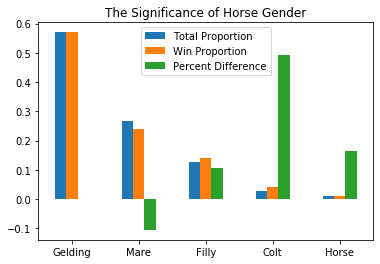

In [25]:
index1 = ['Gelding','Mare','Filly','Colt','Horse']

df1 = pd.DataFrame({'Total Proportion': horse_sex_pop,'Win Proportion': horse_sex_win,
                    'Percent Difference': horse_sex_percent_difference}, index=index1)

ax = df1.plot.bar(rot=0,title='The Significance of Horse Gender')

### Using the Pearson's chi-squared, I find horse gender is significant:

In [26]:
observed1 = sex_pop_cleaned_win.sex.value_counts().sort_values(ascending=False).drop('Unknown').values

expected_percentages1 = horse_sex_pop.values
expected1 = [x*observed1.sum() for x in expected_percentages1]

test_stat1, p_value1 = chisquare(observed1, expected1)

test_stat1, p_value1

(196.24429401115708, 2.4113691661853285e-41)

## For horse age_z (z-scores):

In [27]:
#Removing races where there is only one age
age_pop_cleaned = column_cleaner(df_cleaned, df_grouped, 'age_z')

age_pop_cleaned_win = cleaned_win_df(age_pop_cleaned)

In [28]:
age_pop_cleaned.age_z.describe()

count   173889.00
mean         0.00
std          0.95
min         -3.33
25%         -0.71
50%         -0.17
75%          0.63
max          3.88
Name: age_z, dtype: float64

In [29]:
age_pop_cleaned_win.age_z.describe()

count   17428.00
mean       -0.24
std         0.88
min        -3.33
25%        -0.86
50%        -0.41
75%         0.30
max         3.61
Name: age_z, dtype: float64

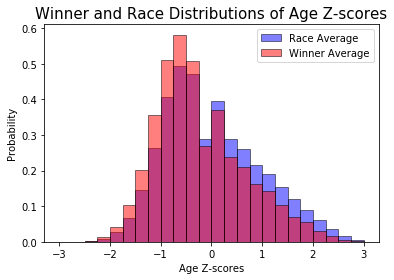

In [30]:
data2a = age_pop_cleaned.age_z.dropna().values
data2b = age_pop_cleaned_win.age_z.dropna().values

plt.title("Winner and Race Distributions of Age Z-scores", fontsize=15)

plt.hist(data2a, density=True, bins=24, range=(-3,3), label='Race Average', 
         color='b', alpha=.5, edgecolor='k')

plt.hist(data2b, density=True, bins=24, range=(-3,3), label='Winner Average',
         color='r', alpha=.5, edgecolor='k')

plt.legend(loc='upper right')
plt.xlabel('Age Z-scores')
plt.ylabel('Probability');

### Using a 2-sample T-test, I find that Age Z-scores is significant:

In [31]:
test_stat2, p_value2 = ttest_ind(data2a, data2b)

test_stat2, p_value2

(31.555501940416974, 5.495528873695373e-218)

### Does condition affect the win distribution of age? Specifically, do older horses perform worse in bad conditions?

In [32]:
condit_age_pop = age_pop_cleaned[age_pop_cleaned.condition == 'HEAVY']

In [33]:
condit_age_pop_win = cleaned_win_df(condit_age_pop)

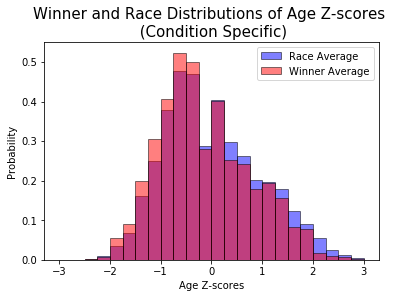

In [34]:
data2c = condit_age_pop.age_z.dropna().values
data2d = condit_age_pop_win.age_z.dropna().values

plt.title("Winner and Race Distributions of Age Z-scores \n (Condition Specific)", fontsize=15)

plt.hist(data2c, density=True, bins=24, range=(-3,3), label='Race Average', 
         color='b', alpha=.5, edgecolor='k')

plt.hist(data2d, density=True, bins=24, range=(-3,3), label='Winner Average',
         color='r', alpha=.5, edgecolor='k')

plt.legend(loc='upper right')
plt.xlabel('Age Z-scores')
plt.ylabel('Probability');

### Condition depended T-test for Age Z-scores: 

In [35]:
test_stat2, p_value2 = ttest_ind(data2c, data2d)

test_stat2, p_value2

(6.335284227796313, 2.4194653311198434e-10)

### It appears as though bad track conditions actually level out the age discrepancies, maybe because they have more experience with those bad conditions.

## For horse handicap weight_z (z-scores):

In [36]:
#Removing races where there is only one age
weight_pop_cleaned = column_cleaner(df_cleaned, df_grouped, 'weight_z')

weight_pop_cleaned_win = cleaned_win_df(weight_pop_cleaned)

In [37]:
weight_pop_cleaned.weight_z.describe()

count   188773.00
mean        -0.00
std          0.95
min         -3.88
25%         -0.75
50%         -0.06
75%          0.74
max          3.95
Name: weight_z, dtype: float64

In [38]:
weight_pop_cleaned_win.weight_z.describe()

count   19069.00
mean        0.21
std         0.95
min        -3.88
25%        -0.57
50%         0.27
75%         0.90
max         3.53
Name: weight_z, dtype: float64

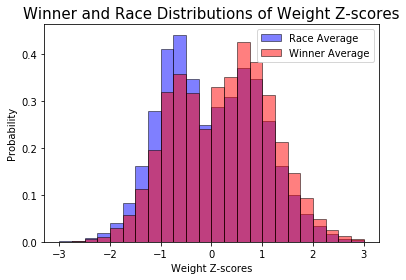

In [39]:
data3a = weight_pop_cleaned.weight_z.dropna().values
data3b = weight_pop_cleaned_win.weight_z.dropna().values

plt.title("Winner and Race Distributions of Weight Z-scores", fontsize=15)

plt.hist(data3a, density=True, bins=24, range=(-3,3), label='Race Average', 
         color='b', alpha=.5, edgecolor='k')

plt.hist(data3b, density=True, bins=24, range=(-3,3), label='Winner Average',
         color='r', alpha=.5, edgecolor='k')

plt.legend(loc='upper right')
plt.xlabel('Weight Z-scores')
plt.ylabel('Probability');

### Using a 2-sample T-test, again I find that Weight Z-scores is significant:

In [40]:
test_stat3, p_value3 = ttest_ind(data3a, data3b)

test_stat3, p_value3

(-28.822130207835215, 2.5976728545751035e-182)

## For prize money, using prize_money_per_start_z (z-scores):

In [41]:
money_pop_cleaned = column_cleaner(df_cleaned, df_grouped, 'prize_money_per_start_z')

money_pop_cleaned_win = cleaned_win_df(weight_pop_cleaned)

In [42]:
money_pop_cleaned.prize_money_per_start_z.describe()

count   150865.00
mean         0.00
std          0.95
min         -2.82
25%         -0.66
50%         -0.24
75%          0.49
max          3.84
Name: prize_money_per_start_z, dtype: float64

In [43]:
#Winner prize money 
money_pop_cleaned_win.prize_money_per_start_z.describe()

count   15197.00
mean        0.62
std         1.04
min        -2.13
25%        -0.22
50%         0.46
75%         1.40
max         3.83
Name: prize_money_per_start_z, dtype: float64

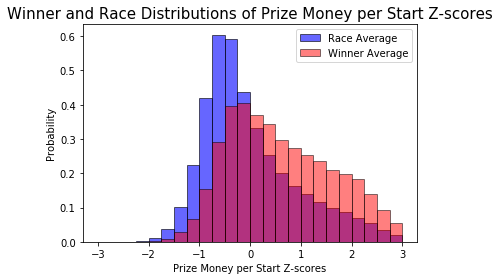

In [44]:
data4a = money_pop_cleaned.prize_money_per_start_z.dropna().values
data4b = money_pop_cleaned_win.prize_money_per_start_z.dropna().values

plt.title("Winner and Race Distributions of Prize Money per Start Z-scores",
          fontsize=15)

plt.hist(data4a, density=True, bins=24, range=(-3,3), label='Race Average',
         color='b', alpha=.6, edgecolor='k')

plt.hist(data4b, density=True, bins=24, range=(-3,3), label='Winner Average',
         color='r', alpha=.5, edgecolor='k')

plt.legend(loc='upper right')
plt.xlabel('Prize Money per Start Z-scores')
plt.ylabel('Probability');

### Using a 2-sample T-test, I find that Prize Money per Start Z-scores is significant:


In [45]:
test_stat4, p_value4 = ttest_ind(data4a, data4b)

test_stat4, p_value4

(-76.41990201705845, 0.0)

## For overall wins:

In [46]:
overall_win_pop_cleaned = column_cleaner(df_cleaned, df_grouped, 'overall_win_percent_z')

overall_win_pop_cleaned_win = cleaned_win_df(overall_win_pop_cleaned)

In [47]:
overall_win_pop_cleaned.overall_win_percent_z.describe()

count   129668.00
mean         0.00
std          0.95
min         -2.66
25%         -0.66
50%         -0.21
75%          0.53
max          3.75
Name: overall_win_percent_z, dtype: float64

In [48]:
overall_win_pop_cleaned_win.overall_win_percent_z.describe()

count   13167.00
mean        0.31
std         1.02
min        -2.65
25%        -0.46
50%         0.13
75%         1.01
max         3.59
Name: overall_win_percent_z, dtype: float64

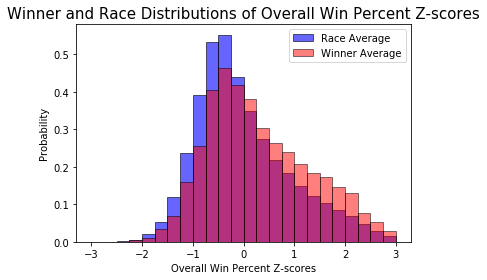

In [49]:
data5a = overall_win_pop_cleaned.overall_win_percent_z.dropna().values
data5b = overall_win_pop_cleaned_win.overall_win_percent_z.dropna().values

plt.title("Winner and Race Distributions of Overall Win Percent Z-scores",
          fontsize=15)

plt.hist(data5a, density=True, bins=24, range=(-3,3), label='Race Average',
         color='b', alpha=.6, edgecolor='k')

plt.hist(data5b, density=True, bins=24, range=(-3,3), label='Winner Average',
         color='r', alpha=.5, edgecolor='k')

plt.legend(loc='upper right')
plt.xlabel('Overall Win Percent Z-scores')
plt.ylabel('Probability');

### Using a 2-sample T-test, I find that Overall Win Percent Z-scores is significant:

In [50]:
test_stat5, p_value5 = ttest_ind(data5a, data5b)

test_stat5, p_value5

(-35.60594650187907, 1.8659451269816977e-276)

### There is high variance in the 100% column (aka beginner's luck). How many races before the 100% column is properly represented? That is, how many races is considered statistically significant?

### It seems that a minimum of 5 races for all horses in the race gives the percent difference bar graph an exponential appearance. The other Github file has the graph showing this behavior.

In [51]:
overall_win_pop_grouped = overall_win_pop_cleaned.groupby(['date','venue_name',
                                                           'market_name'])

overall_starts_indices = overall_win_pop_grouped.overall_starts.agg('min').where(lambda x:x >= 5).dropna().index

overall_starts_cleaned = overall_win_pop_cleaned.loc[overall_starts_indices].drop_duplicates()

overall_starts_cleaned_win = cleaned_win_df(overall_starts_cleaned)

In [52]:
overall_starts_cleaned.overall_win_percent_z.describe()

count   85608.00
mean        0.00
std         0.95
min        -2.66
25%        -0.69
50%        -0.15
75%         0.59
max         3.40
Name: overall_win_percent_z, dtype: float64

In [53]:
overall_starts_cleaned_win.overall_win_percent_z.describe()

count   8806.00
mean       0.30
std        1.00
min       -2.65
25%       -0.46
50%        0.18
75%        1.01
max        3.40
Name: overall_win_percent_z, dtype: float64

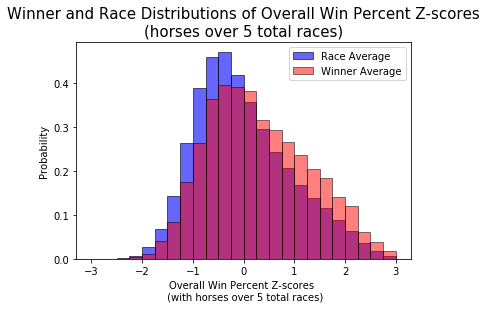

In [54]:
data6a = overall_starts_cleaned.overall_win_percent_z.dropna().values
data6b = overall_starts_cleaned_win.overall_win_percent_z.dropna().values

plt.title("Winner and Race Distributions of Overall Win Percent Z-scores\n(horses over 5 total races)",
          fontsize=15)

plt.hist(data6a, density=True, bins=24, range=(-3,3), label='Race Average',
         color='b', alpha=.6, edgecolor='k')

plt.hist(data6b, density=True, bins=24, range=(-3,3), label='Winner Average',
         color='r', alpha=.5, edgecolor='k')

plt.legend(loc='upper right')
plt.xlabel('Overall Win Percent Z-scores \n (with horses over 5 total races)')
plt.ylabel('Probability');

### Using a 2-sample T-test, I find that Overall Win Percent Z-scores (with horses over 5 total races) is significant:

In [55]:
test_stat6, p_value6 = ttest_ind(data6a, data6b)

test_stat6, p_value6

(-28.057312959704664, 1.6702355295015772e-172)

## For Barrier:

In [56]:
barrier_pop_cleaned = column_cleaner(df_cleaned, df_grouped, 'barrier')

barrier_grouped = barrier_pop_cleaned.groupby(['date','venue_name','market_name'])

barrier_indices = barrier_grouped.barrier.value_counts().where(lambda x:x == 1).dropna().index.droplevel('barrier')

barrier_pop_cleaned = barrier_pop_cleaned.loc[barrier_indices]

barrier_pop_cleaned_win = cleaned_win_df(barrier_pop_cleaned)

In [57]:
barrier_pop = barrier_pop_cleaned.barrier.value_counts(normalize=True).sort_index().drop([18.00,19.00,20.00])

barrier_win = barrier_pop_cleaned_win.barrier.value_counts(normalize=True).sort_index().drop(18.00)

barrier_percent_difference = (barrier_win - barrier_pop)/barrier_pop

barrier_percent_difference

1.00     0.22
2.00     0.03
3.00     0.05
4.00     0.09
5.00     0.12
6.00     0.12
7.00    -0.02
8.00    -0.10
9.00    -0.11
10.00   -0.16
11.00   -0.19
12.00   -0.19
13.00   -0.35
14.00   -0.36
15.00   -0.13
16.00   -0.39
17.00   -0.15
Name: barrier, dtype: float64

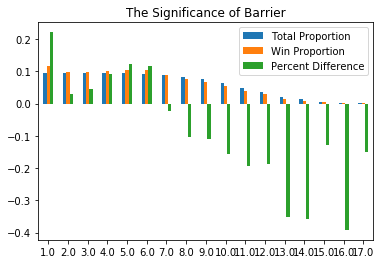

In [58]:
index7 = barrier_percent_difference.index

df7 = pd.DataFrame({'Total Proportion': barrier_pop,'Win Proportion': barrier_win,
                    'Percent Difference': barrier_percent_difference}, index=index7)

ax = df7.plot.bar(rot=0, title='The Significance of Barrier')

### Why is barrier 1 so overrepresented? Is there a problem with the data? There doesn't appear to be.

### Using the Pearson's chi-squared test, I find that barrier is significant:

In [59]:
observed7 = barrier_pop_cleaned_win.barrier.value_counts().sort_index().drop(18.00).values
expected_percentages7 = barrier_pop.values
expected7 = [x*observed7.sum() for x in expected_percentages7]

test_stat7, p_value7 = chisquare(observed7, expected7)

test_stat7, p_value7

(3749.5577711230185, 0.0)

### Does the length of a race negate or alter the effect of starting barrier?

In [60]:
barr_dist_indices = barrier_pop_cleaned.distance.where(lambda x:x>=1800).dropna().index

barr_dist_cleaned = barrier_pop_cleaned.loc[barr_dist_indices]

barr_dist_cleaned_win = cleaned_win_df(barr_dist_cleaned)

In [61]:
barr_dist_pop = barr_dist_cleaned.barrier.value_counts(normalize=True).sort_index().drop(18.00)

barr_dist_win = barr_dist_cleaned_win.barrier.value_counts(normalize=True).sort_index().drop(18.00)

barr_dist_percent_difference = (barr_dist_win - barr_dist_pop)/barr_dist_pop

barr_dist_percent_difference

1.00     0.29
2.00    -0.04
3.00     0.15
4.00     0.09
5.00     0.05
6.00     0.11
7.00     0.09
8.00     0.03
9.00    -0.04
10.00   -0.15
11.00   -0.17
12.00   -0.29
13.00   -0.32
14.00   -0.34
15.00   -0.47
16.00   -0.78
17.00     nan
Name: barrier, dtype: float64

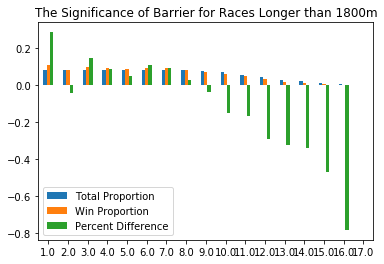

In [62]:
index7a = barr_dist_percent_difference.index

df7a = pd.DataFrame({'Total Proportion': barr_dist_pop,'Win Proportion': barr_dist_win,
                    'Percent Difference': barr_dist_percent_difference}, index=index7a)

ax = df7a.plot.bar(rot=0, title='The Significance of Barrier for Races Longer than 1800m')

### It appears that there may be an even bigger distinction with barrier 1 with longer race distances. However, the other barriers seem to even out.

## For jockey gender: 

#### Overall percentage of men and women in races where both are represented:

In [63]:
#Drops races where there is only one jockey gender, meaning that the other gender can't win
jockey_sex_cleaned = column_cleaner(df_cleaned, df_grouped, 'jockey_sex')

jockey_sex_cleaned_win = cleaned_win_df(jockey_sex_cleaned)

In [64]:
jockey_sex_cleaned.jockey_sex.value_counts(normalize=True)
#This amount is the sum of all 'male' and 'female' jockeys added together and THEN 'normalized'

Male     0.75
Female   0.25
Name: jockey_sex, dtype: float64

#### Win percentage of those races:

In [65]:
#Isolates wins in races with both jockey genders represented
jockey_sex_cleaned_win.jockey_sex.value_counts(normalize=True, dropna=False)

Male     0.79
Female   0.21
Name: jockey_sex, dtype: float64

In [66]:
#Finding the percent difference between win and total
jockey_sex_pop = jockey_sex_cleaned.jockey_sex.value_counts(normalize=True,
                                                            dropna=False).values

jockey_sex_win = jockey_sex_cleaned_win.jockey_sex.value_counts(normalize=True,
                                                                dropna=False).values

jockey_sex_percent_difference = (jockey_sex_win - jockey_sex_pop)/jockey_sex_pop

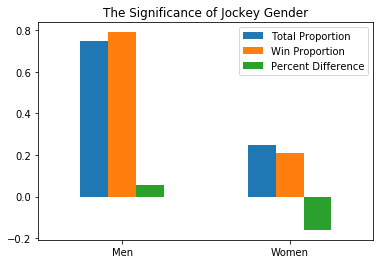

In [67]:
index8 = ['Men','Women']

df8 = pd.DataFrame({'Total Proportion': jockey_sex_pop,'Win Proportion': jockey_sex_win ,
                    'Percent Difference': jockey_sex_percent_difference}, index=index8)

ax = df8.plot.bar(rot=0, title='The Significance of Jockey Gender')

### Using a 2-proportion z-test, I find that jockey gender is significant with a p-value of 2.3E-30
#### (There is currently a bug with the statsmodels library concerning compatibility with scipy, so I used a scientific calculator)

## How far back does form (previous finishes) become irrelevant?

### The distribution after 1 start:

In [68]:
last_start_pop_cleaned = column_cleaner(df_cleaned, df_grouped, 'last_start1')

last_start_pop_cleaned_win = cleaned_win_df(last_start_pop_cleaned)

In [69]:
#Finding the percent difference between win and total
last_start_pop = last_start_pop_cleaned.last_start1.value_counts(normalize=True,
                                                                 dropna=False)

last_start_win = last_start_pop_cleaned_win.last_start1.value_counts(normalize=True,
                                                                     dropna=False)

last_start_percent_difference = (last_start_win - last_start_pop)/last_start_pop

last_start_percent_difference

1          0.47
2          0.54
3          0.25
4          0.09
5         -0.07
6         -0.17
7         -0.23
8         -0.34
9         -0.44
scratch   -0.12
ten+      -0.47
Name: last_start1, dtype: float64

In [70]:
index9 = ['1','2','3','4','5','6','7','8','9','ten+','scratch','fell','none']

df9 = pd.DataFrame({'Total Proportion': last_start_pop,'Win Proportion': last_start_win,
                    'Percent Difference': last_start_percent_difference}, index=index9)

### After 5 starts:

In [71]:
last_start_pop_cleaned = column_cleaner(df_cleaned, df_grouped, 'last_start5')

last_start_pop_cleaned_win = cleaned_win_df(last_start_pop_cleaned)

In [72]:
#Finding the percent difference between win and total
last_start_pop = last_start_pop_cleaned.last_start5.value_counts(normalize=True,
                                                                 dropna=False)

last_start_win = last_start_pop_cleaned_win.last_start5.value_counts(normalize=True,
                                                                     dropna=False)

last_start_percent_difference = (last_start_win - last_start_pop)/last_start_pop

In [73]:
index10 = ['1','2','3','4','5','6','7','8','9','ten+','scratch','fell','none']

df10 = pd.DataFrame({'Total Proportion': last_start_pop,'Win Proportion': last_start_win,
                    'Percent Difference': last_start_percent_difference}, index=index10)

### After 10 starts:

In [74]:
last_start_pop_cleaned = column_cleaner(df_cleaned, df_grouped, 'last_start10')

last_start_pop_cleaned_win = cleaned_win_df(last_start_pop_cleaned)

In [75]:
#Finding the percent difference between win and total
last_start_pop = last_start_pop_cleaned.last_start10.value_counts(normalize=True,
                                                                 dropna=False)

last_start_win = last_start_pop_cleaned_win.last_start10.value_counts(normalize=True,
                                                                     dropna=False)

last_start_percent_difference = (last_start_win - last_start_pop)/last_start_pop

In [76]:
index11 = ['1','2','3','4','5','6','7','8','9','ten+','scratch','fell','none']

df11 = pd.DataFrame({'Total Proportion': last_start_pop,'Win Proportion': last_start_win,
                    'Percent Difference': last_start_percent_difference}, index=index11)

### After 13 starts:

In [77]:
last_start_pop_cleaned = column_cleaner(df_cleaned, df_grouped, 'last_start13')

last_start_pop_cleaned_win = cleaned_win_df(last_start_pop_cleaned)

In [78]:
#Finding the percent difference between win and total
last_start_pop = last_start_pop_cleaned.last_start13.value_counts(normalize=True,
                                                                 dropna=False)

last_start_win = last_start_pop_cleaned_win.last_start13.value_counts(normalize=True,
                                                                     dropna=False)

last_start_percent_difference = (last_start_win - last_start_pop)/last_start_pop

last_start_percent_difference

1          0.01
2         -0.01
3         -0.03
4         -0.10
5         -0.13
6         -0.11
7         -0.21
8         -0.15
9         -0.20
fell       0.14
none       0.22
scratch   -0.05
ten+      -0.23
Name: last_start13, dtype: float64

In [79]:
index12 = ['1','2','3','4','5','6','7','8','9','ten+','scratch','fell','none']

df12 = pd.DataFrame({'Total Proportion': last_start_pop,'Win Proportion': last_start_win,
                    'Percent Difference': last_start_percent_difference}, index=index12)

### Graphing form data:

Text(0.5, 1.0, 'The Significance of 13 Results Ago')

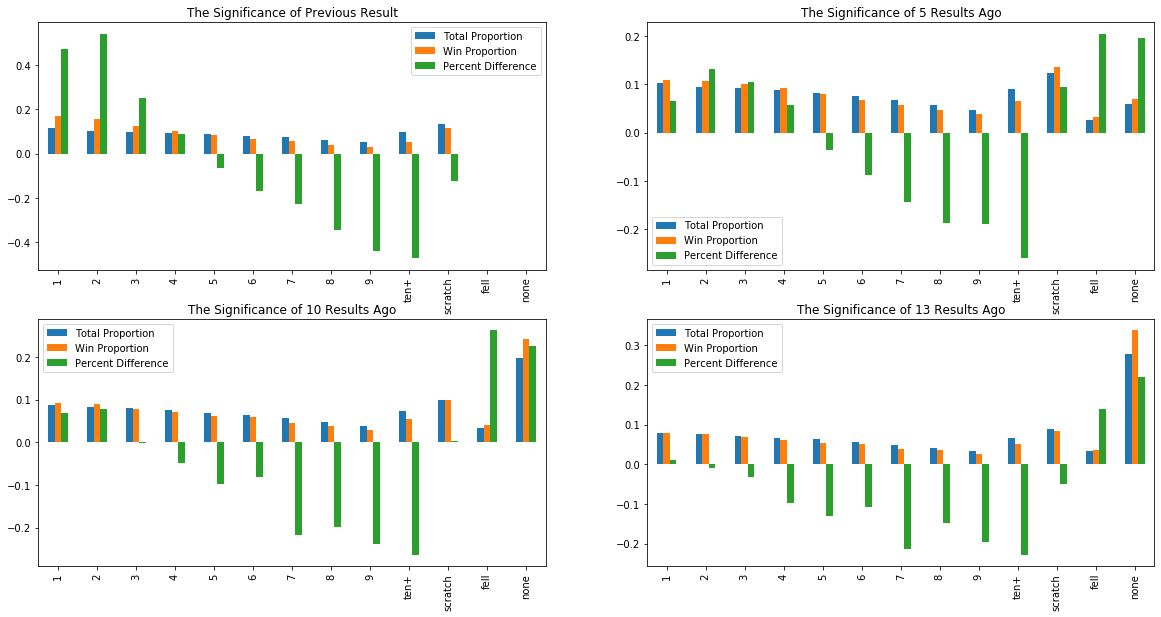

In [80]:
fig,ax1 = plt.subplots(2, 2)

df9.plot.bar(ax=ax1[0,0],figsize=(20, 10)).set_title('The Significance of Previous Result')
df10.plot.bar(ax=ax1[0,1],figsize=(20, 10)).set_title('The Significance of 5 Results Ago')
df11.plot.bar(ax=ax1[1,0],figsize=(20, 10)).set_title('The Significance of 10 Results Ago')
df12.plot.bar(ax=ax1[1,1],figsize=(20, 10)).set_title('The Significance of 13 Results Ago')

# How often would you win and what would be your expected return if you always bet on the favorite?

In [81]:
odds_cleaned = column_cleaner(df_cleaned, df_grouped, 'bf_odds')

In [82]:
#creates dataframe with a unique index
odds_cleaned['uniq_idx'] = range(len(odds_cleaned))
odds_cleaned_uniq_idx = odds_cleaned.set_index('uniq_idx',append=True)
uniq_idx_grouped = odds_cleaned_uniq_idx.groupby(['date','venue_name',
                                                  'market_name'])

odds_cleaned_uniq_idx.head()

position_again  bf_odds  \
date       venue_name market_name    uniq_idx                            
2016-06-27 Echuca     R10 1400m Hcap 0                   1.00    18.50   
                                     1                   2.00    16.50   
                                     2                   3.00    11.50   
                                     3                    nan    19.00   
                                     4                    nan     7.60   

                                              condition  barrier      sex  \
date       venue_name market_name    uniq_idx                               
2016-06-27 Echuca     R10 1400m Hcap 0            HEAVY    12.00     Mare   
                                     1            HEAVY     8.00  Gelding   
                                     2            HEAVY     1.00  Gelding   
                                     3            HEAVY     5.00  Gelding   
                                     4            HEAVY     7.00     Mare   

                                              jockey_sex  days_since_last_run  \
date       venue_name market_name    uniq_idx                                   
2016-06-27 Echuca     R10 1400m Hcap 0              Male                16.00   
                                     1              Male                18.00   
                                     2              Male                13.00   
                                     3              Male                16.00   
                                     4              Male                13.00   

                                               overall_starts  track_starts  \
date       venue_name market_name    uniq_idx                                 
2016-06-27 Echuca     R10 1400m Hcap 0                  26.00         10.00   
                                     1                  12.00          1.00   
                                     2                  20.00          7.00   
                                     3                  31.00          2.00   
                                     4                   6.00          0.00   

                                               distance_starts  ...  \
date       venue_name market_name    uniq_idx                   ...   
2016-06-27 Echuca     R10 1400m Hcap 0                   12.00  ...   
                                     1                    9.00  ...   
                                     2                   10.00  ...   
                                     3                   16.00  ...   
                                     4                    3.00  ...   

                                               overall_win_percent_z  \
date       venue_name market_name    uniq_idx                          
2016-06-27 Echuca     R10 1400m Hcap 0                         -0.09   
                                     1                          0.06   
                                     2                         -0.72   
                                     3                         -0.76   
                                     4                          2.00   

                                               overall_place_percent_z  \
date       venue_name market_name    uniq_idx                            
2016-06-27 Echuca     R10 1400m Hcap 0                           -0.24   
                                     1                           -0.12   
                                     2                            1.19   
                                     3                           -0.17   
                                     4                            1.52   

                                               distance_win_percent_z  \
date       venue_name market_name    uniq_idx                           
2016-06-27 Echuca     R10 1400m Hcap 0                           0.19   
                                     1                           0.09   
                                     2              

In [83]:
#finds index of favorite for every race
bf_min_indices = uniq_idx_grouped.bf_odds.idxmin

#finds row for each favorite
min_odds_cleaned = odds_cleaned_uniq_idx.loc[bf_min_indices]

#finds favorites that won
min_odds_win = cleaned_win_df(min_odds_cleaned)

odds_pop = len(min_odds_cleaned)
odds_win = len(min_odds_win)

#finds average win of favorite that won
average = min_odds_win.bf_odds.mean()

print('Number of favorites:',odds_pop)
print('Number of favorites that win:',odds_win)
print('Average odds of favorite that wins:',average)

Number of favorites: 21587
Number of favorites that win: 7410
Average odds of favorite that wins: 2.9872685560053975


### How often the favorite wins:
#### Similar to value found here:
https://betmix.com/how-often-does-the-favorite-win-a-horse-race/#:~:text=On%20average%20favorites%20win%20about,dirt%20races%20than%20turf%20races.

In [84]:
odds_win/odds_pop

0.3432621485153101

### The expected return if betting 1 dollar on favorite every race:

In [85]:
(average*odds_win - odds_pop)/odds_pop

0.025416222726640857

# Machine Learning Process:

## Dropping null-majority features, creating dummy variables, and imputing:

In [86]:
df_cleaned_test = df_cleaned.copy()

df_cleaned_test.drop(['condition_place_percent_z','condition_win_percent_z',
                      'distance_place_percent_z','distance_win_percent_z'],
                     axis=1,inplace=True)

#drops last_start 11 through 20 to match information provided on racing websites
for i in range(10,20):
    df_cleaned_test.drop('last_start'+str(i+1),axis=1,inplace=True)
    
df_cleaned_test.reset_index(drop=True,inplace=True)

In [87]:
#Modifying categorical groups
df_cleaned_test.position_again = df_cleaned_test.position_again.replace([2,3,np.nan],[0,0,0])

#Creates new target column based on odds
conditions = [(df_cleaned_test['position_again'] == 1),
              (df_cleaned_test['position_again'] == 2) | (df_cleaned_test['position_again'] == 3)]

# Used for making regression model
#choices = [df_cleaned_test['bf_odds'], place_odds_estimator(df_cleaned_test['bf_odds'])]
#df_cleaned_test['target_odds'] = np.select(conditions, choices, default=0)

categorical_list = ['sex','jockey_sex','condition','barrier']
for i in range(10):
    categorical_list.append('last_start'+str(i+1)) 

df_cleaned_test = pd.get_dummies(df_cleaned_test,columns=categorical_list,drop_first=True,dummy_na=1)

In [88]:
df_cleaned_test.isnull().sum()

position_again              0
bf_odds                     0
days_since_last_run     13035
overall_starts          13035
track_starts            13035
                        ...  
last_start10_fell           0
last_start10_none           0
last_start10_scratch        0
last_start10_ten+           0
last_start10_nan            0
Length: 183, dtype: int64

### Imputing nans:

In [89]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split

In [90]:
y = df_cleaned_test['position_again']
X = df_cleaned_test.drop(['position_again','bf_odds'],axis=1)

# For regression model experimentation:
# y = df_cleaned_test['target_odds']
# X = df_cleaned_test.drop(['position_again','target_odds'],axis=1)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.9, random_state=0)

In [92]:
imp_mean = IterativeImputer(random_state=0)
imp_mean.fit(X_train,y_train)
transformed_X_test = imp_mean.transform(X_test)

# Transformaing np.array output back into pandas dataframe
transformed_X_test = pd.DataFrame(data=transformed_X_test,index=y_test.index,columns=X_test.columns)

In [93]:
transformed_X_test.isnull().sum().sum() #Total null values after transformation

0

## Shuffling and splitting the grouped data:

In [94]:
#classifiers -- All have balancing option for imbalanced datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

#for function below
from sklearn.model_selection import StratifiedKFold
from time import time
from sklearn.metrics import make_scorer,confusion_matrix,accuracy_score,\
    precision_score,recall_score,f1_score,roc_auc_score,matthews_corrcoef

### The dataset is imbalanced and this needs to be accounted for, so I use models with a balancing option.

In [95]:
#for xgboost scale_pos_weight
negative = len(df_cleaned_test[df_cleaned_test.position_again ==0])
positive = len(df_cleaned_test[df_cleaned_test.position_again ==1])
xgb_weight = negative/positive

xgb_weight

8.61029170763684

In [96]:
clf_A = SGDClassifier(random_state=0,class_weight='balanced')

clf_B = LogisticRegression(random_state=0,class_weight='balanced')

clf_D = RandomForestClassifier(random_state=0,max_depth=10,class_weight='balanced')

clf_F = DecisionTreeClassifier(random_state=0,max_depth=5,class_weight='balanced')

clf_J = xgb.XGBClassifier(random_state=0,scale_pos_weight=xgb_weight)

### Creates a function to split data and fit, predict, and score models:

In [97]:
def metrics_function(target,pred):
    return accuracy_score(target, pred),precision_score(target, pred),\
        recall_score(target, pred),f1_score(target, pred),\
        roc_auc_score(target, pred),matthews_corrcoef(target, pred)

def FOLD_TEST(clf,X_all,y_all,folds_num,row_factor):
    start=time()
    
    KFLD=StratifiedKFold(n_splits=folds_num,random_state=0,shuffle=True)
    print ('{}:'.format(clf.__class__.__name__),'\n')
    
    acc_list_train=[]
    acc_list_test=[]
    prc_list_train=[]
    prc_list_test=[]
    rcal_list_train=[]
    rcal_list_test=[]
    f1_list_train=[]
    f1_list_test=[]
    matt_list_train=[]
    matt_list_test=[]
    AUC_list_train=[]
    AUC_list_test=[]
    
    samp_size=X_all.shape[0]//row_factor
    
    true_values = []
    predict_values =[]
    
    for fold,(train_index,target_index) in enumerate(KFLD.split(X_all[:samp_size],
                                                                y_all[:samp_size])):
        X_train=X_all.iloc[train_index].values
        y_train=y_all.iloc[train_index].values

        X_test=X_all.iloc[target_index].values
        y_test=y_all.iloc[target_index].values
        
        clf.fit(X_train,y_train)
        y_pred1=clf.predict(X_train)
        y_pred2=clf.predict(X_test)

        train_acc,train_prc,train_rcal,train_f1,train_auc,train_matt=metrics_function(y_train,y_pred1)
        
        test_acc,test_prc,test_rcal,test_f1,test_auc,test_matt=metrics_function(y_test,y_pred2)
        
        acc_list_train.append(train_acc)
        acc_list_test.append(test_acc)
        prc_list_train.append(train_prc)
        prc_list_test.append(test_prc)
        rcal_list_train.append(train_rcal)
        rcal_list_test.append(test_rcal)
        
        f1_list_train.append(train_f1)
        f1_list_test.append(test_f1)
        matt_list_train.append(train_matt)
        matt_list_test.append(test_matt)
        AUC_list_train.append(train_auc)
        AUC_list_test.append(test_auc)
        
        true_values = true_values + list(zip(target_index,y_test))
        predict_values = predict_values + list(zip(target_index,y_pred2))
        
    print("Averages:"'\n')
    
    print("Train acc: {}, Test acc: {}".format(np.mean(acc_list_train),
                                               np.mean(acc_list_test)))
    print("Train prc: {}, Test prc: {}".format(np.mean(prc_list_train),
                                               np.mean(prc_list_test)))
    print("Train recall: {}, Test recall: {}".format(np.mean(rcal_list_train),
                                                     np.mean(rcal_list_test)),'\n')
    
    print("Train f1: {}, Test f1: {}".format(np.mean(f1_list_train),
                                             np.mean(f1_list_test)))
    print("Train MattCC: {}, Test MattCC: {}".format(np.mean(matt_list_train),
                                                     np.mean(matt_list_test)))
    print("Train AUC: {}, Test AUC: {}".format(np.mean(AUC_list_train),
                                               np.mean(AUC_list_test)),'\n'*2)
        
    print("Sample Size: {}, Folds Num: {}, Time: {}".format(samp_size,folds_num,
                                                            time()-start),'\n'*2)
    
    total_picks = []
    correct_idx = []

    for ((a,b),(c,d)) in list(zip(true_values,predict_values)):
        if (b==1)&(d==1):
            correct_idx.append(a)
        if d==1:
            total_picks.append(c)

    win_odds_list=[]

    for a in correct_idx:
        win_odds_list.append(df_cleaned_test.bf_odds.iloc[a])

    average_win=np.mean(win_odds_list)
    
    print("Total Picks:",len(total_picks),"Average Win Odds:",average_win)
    print("Total Return:",average_win*len(correct_idx)-len(total_picks))
    print("Average Expected Return:",(average_win*len(correct_idx)-len(total_picks))/len(total_picks))

### The meaningful values here are
- Test prc (precision)
- Sample Size
- Total Picks
- Average Win Odds
- Total Return
- Average Expected Return.

In [98]:
FOLD_TEST(clf_A, transformed_X_test, y_test, 5, 2)

SGDClassifier: 

Averages:

Train acc: 0.5758445305961822, Test acc: 0.5756617250693761
Train prc: 0.21720918387033383, Test prc: 0.20402291301387415
Train recall: 0.42356810254632177, Test recall: 0.42434103191390926 

Train f1: 0.1148730366050105, Test f1: 0.11560869216778565
Train MattCC: 0.04409037737202122, Test MattCC: 0.04261030213847091
Train AUC: 0.5085484017263331, Test AUC: 0.5087928724524229 


Sample Size: 92361, Folds Num: 5, Time: 41.8225314617157 


Total Picks: 37737 Average Win Odds: 32.124860225600784
Total Return: 93268.18
Average Expected Return: 2.471531388292657


In [99]:
FOLD_TEST(clf_B, transformed_X_test, y_test, 5, 2)

LogisticRegression: 

Averages:

Train acc: 0.6510161193881935, Test acc: 0.6493758123035933
Train prc: 0.17766671404144446, Test prc: 0.17505172134308283
Train recall: 0.6486577646702337, Test recall: 0.6382263448706522 

Train f1: 0.2789334500480357, Test f1: 0.274737305967815
Train MattCC: 0.18869388445990523, Test MattCC: 0.18179592030923053
Train AUC: 0.6499738974408571, Test AUC: 0.6444485198673503 


Sample Size: 92361, Folds Num: 5, Time: 52.594948053359985 


Total Picks: 35041 Average Win Odds: 31.529696772089984
Total Return: 158362.15999999997
Average Expected Return: 4.519339059958334


In [100]:
FOLD_TEST(clf_D, transformed_X_test, y_test, 5, 2)

RandomForestClassifier: 

Averages:

Train acc: 0.7160841427988319, Test acc: 0.6900099467444639
Train prc: 0.2203199445171323, Test prc: 0.17696415375033314
Train recall: 0.6804964563482381, Test recall: 0.5418788822312518 

Train f1: 0.3328463225649999, Test f1: 0.26677755724051727
Train MattCC: 0.2620109547908656, Test MattCC: 0.16324997224835722
Train AUC: 0.7003569895034241, Test AUC: 0.6245466918709129 


Sample Size: 92361, Folds Num: 5, Time: 9.467440366744995 


Total Picks: 29436 Average Win Odds: 31.85351382488479
Total Return: 136457.09999999998
Average Expected Return: 4.635721565430085


In [101]:
FOLD_TEST(clf_F, transformed_X_test, y_test, 5, 2)

DecisionTreeClassifier: 

Averages:

Train acc: 0.6171571096285433, Test acc: 0.6147616919260648
Train prc: 0.16730351984150665, Test prc: 0.16309715247202095
Train recall: 0.6724848997764148, Test recall: 0.6528969379378713 

Train f1: 0.26781981871421373, Test f1: 0.2608520420278773
Train MattCC: 0.17548644855058967, Test MattCC: 0.1632239857661963
Train AUC: 0.6416080088005941, Test AUC: 0.6316146321109296 


Sample Size: 92361, Folds Num: 5, Time: 7.54425311088562 


Total Picks: 38520 Average Win Odds: 32.10891792828686
Total Return: 162963.46000000002
Average Expected Return: 4.230619418483905


In [102]:
FOLD_TEST(clf_J, transformed_X_test, y_test, 5, 2)

XGBClassifier: 

Averages:

Train acc: 0.6423057307567757, Test acc: 0.6362101002254013
Train prc: 0.1798056764829664, Test prc: 0.17224071344430408
Train recall: 0.6843461624502699, Test recall: 0.6558110565837826 

Train f1: 0.2847829244200046, Test f1: 0.27282141886667116
Train MattCC: 0.20088911051364974, Test MattCC: 0.18088521176006592
Train AUC: 0.6608845615876727, Test AUC: 0.6448722956634925 


Sample Size: 92361, Folds Num: 5, Time: 133.84301710128784 


Total Picks: 36595 Average Win Odds: 31.74943518959226
Total Return: 163521.69
Average Expected Return: 4.468416177073371


### Regression model experimentation:

In [ ]:
from time import time
from sklearn.metrics import make_scorer,confusion_matrix,accuracy_score,\
    precision_score,recall_score,f1_score,roc_auc_score,matthews_corrcoef

from sklearn.model_selection import KFold

from sklearn.linear_model import Ridge, SGDRegressor

from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

In [ ]:
def metrics_function2(target,pred):
    return mean_squared_error(target,pred),mean_absolute_error(target,pred),r2_score(target,pred)

def FOLD_TEST(clf,X_all,y_all,folds_num,row_factor):
    start=time()
    
    KFLD=KFold(n_splits=folds_num,random_state=0,shuffle=True)
    print ('{}:'.format(clf.__class__.__name__),'\n')
    
    MSE_list_train=[]
    MSE_list_test=[]
    MAE_list_train=[]
    MAE_list_test=[]
    R2_list_train=[]
    R2_list_test=[]
    
    samp_size=X_all.shape[0]//row_factor
    
    true_values = []
    predict_values =[]
    
    for fold,(train_index,target_index) in enumerate(KFLD.split(X_all[:samp_size],
                                                                y_all[:samp_size])):
        
        X_train=X_all.iloc[train_index].values
        y_train=y_all.iloc[train_index].values

        X_test=X_all.iloc[target_index].values
        y_test=y_all.iloc[target_index].values
        
        clf.fit(X_train,y_train)
        y_pred1=clf.predict(X_train)
        y_pred2=clf.predict(X_test)

        train_MSE,train_MAE,train_R2=metrics_function2(y_train,y_pred1)
        test_MSE,test_MAE,test_R2=metrics_function2(y_test,y_pred2)
        
        MSE_list_train.append(train_MSE)
        MSE_list_test.append(test_MSE)
        MAE_list_train.append(train_MAE)
        MAE_list_test.append(test_MAE)
        R2_list_train.append(train_R2)
        R2_list_test.append(test_R2)
        
        true_values = true_values + list(zip(target_index,y_test))
        predict_values = predict_values + list(zip(target_index,y_pred2))
    

        
    print("Train MSE: {}, Test MSE: {}".format(np.mean(MSE_list_train),
                                               np.mean(MSE_list_test)),'\n'*2) 
    print("Train MAE: {}, Test MAE: {}".format(np.mean(MAE_list_train),
                                               np.mean(MAE_list_test)),'\n'*2)
    print("Train R2: {}, Test R2: {}".format(np.mean(R2_list_train),
                                             np.mean(R2_list_test)),'\n'*2)   
        
    print("Sample Size: {}, Folds Num: {}, Time: {}".format(samp_size,folds_num,
                                                            time()-start),'\n'*2)
    
    total_picks = []
    correct_idx = []

    for ((a,b),(c,d)) in list(zip(true_values,predict_values)):
        if (b==1)&(d==1):
            correct_idx.append(a)
        if d==1:
            total_picks.append(c)

    win_odds_list=[]

    for a in correct_idx:
        win_odds_list.append(df_cleaned_test.bf_odds.iloc[a])

    average_win=np.mean(win_odds_list)
    
    print("Total Picks:",len(total_picks),"Average Win Odds:",average_win)
    print("Total Return:",average_win*len(correct_idx)-len(total_picks))
    print("Average Expected Return:",(average_win*len(correct_idx)-len(total_picks))/len(total_picks))

In [ ]:
#clf_A3 = 

clf_A2 = Ridge(alpha=1e3,random_state=0)

clf_A1 = SGDRegressor()

In [ ]:
FOLD_TEST(clf_A1,transformed_X_test,y_test,5,1)